# Preamble

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from utils.my_units import *
from superrad import ultralight_boson as ub

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcdefaults()
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
rcParams['mathtext.rm'] = 'Times New Roman' 
rcParams['text.usetex'] = True
rcParams['font.family'] = 'times' #'sans-serif'
font_manager.findfont('serif', rebuild_if_missing=True)
fontsize = 14
rcParams.update({'font.size':fontsize})

# Estimate Number of events

## Functions

In [3]:
# Black hole mass distribution from 2003.03359
Mmin, Mmax = 5, 30
Norm = 0.740741*(Mmax**(1.35)-Mmin**(1.35))/( (Mmax*Mmin)**(1.35))

def dndM(m):
    return 1/Norm*1/m**(2.35)

In [4]:
### Function to compute the strain hTilde as a function of mass, spin, and age

def get_hTilde_grid(freq_GW, MList, aList, tSteps, RMW=20*kpc, tMW = 13.6*1E9*Year):

    hTilde = np.zeros((len(MList), len(aList), tSteps))
    tGrid = np.zeros((len(MList), len(aList), tSteps))

    mu = np.pi*freq_GW*Hz
    
    for i_m, mbh in enumerate(tqdm(MList)):
        alpha = GN*mu*mbh*MSolar

        for i_a, abh0 in enumerate(aList):
            try:
                wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")
                if wf.azimuthal_num()==1:
                    tauGW = wf.gw_time() 
                    tauSR = wf.cloud_growth_time() 

                    tTildeMin = tauGW*Second/tMW*1E-4
                    tTildeMax = 1-tauSR*Second/tMW    
                    tListTemp = np.concatenate([[0], np.geomspace(tTildeMin,tTildeMax,tSteps-1)])
                    tGrid[i_m, i_a, :] = tListTemp

                    hTilde[i_m, i_a, :] = wf.strain_char(tListTemp*tMW/Second, dObs=(RMW/Mpc) )

            except ValueError:
                pass 
            
    return hTilde, tGrid

In [5]:
def get_dfdlogh(hVal, hTilde, tGrid, fMList):
    
    thFnc = np.heaviside((1-hTilde/hVal), np.zeros(hTilde.shape))
    integrand = (hTilde/hVal)**3*thFnc
    
    intOvert = np.trapz(integrand, x=tGrid, axis=2)
    intOvera = np.trapz(intOvert, x=aList, axis=1)
    res = 3*np.trapz(fMList*intOvera, x=MList)
    
    return res    

In [6]:
def get_dfevdlogM(hVal, hTilde, tGrid, fMList):
    
    thFnc = np.heaviside((1-hTilde/hVal), np.zeros(hTilde.shape))
    integrand = (hTilde/hVal)**3*thFnc
    
    intOvert = np.trapz(integrand, x=tGrid, axis=2)
    intOvera = np.trapz(intOvert, x=aList, axis=1)
    res = 3*fMList*intOvera*MList
    
    return res    

In [7]:
def get_dNevdlogM_ip(Ntot=3000, p_ind=0):
    
    hTilde, tGrid = get_hTilde_grid(df_pulsars['F_GW'].iloc[p_ind], MList, aList, tSteps, RMW, tMW ) # GW frequency must be in Hz    
    hUL = df_pulsars['upper limits'].iloc[p_ind]
    
    dfdlogh = np.zeros( (len(hList), len(MList)) )
    fMList = dndM(MList)
    
    for i_h, hVal in enumerate(tqdm(hList)):    
        dfdlogh[i_h, :] = get_dfevdlogM(hVal, hTilde, tGrid, fMList)
        
    selh = (hList > hUL)
    dNevdlogM = np.zeros( MList.shape )
    for i_m, m in enumerate(MList):
        dNevdlogM[i_m] = Ntot*np.trapz(dfdlogh[selh, i_m]/hList[selh], x=hList[selh], axis=0)

    return dNevdlogM

In [46]:
def get_dfdlogh_ip(hList, p_ind=0):
    hTilde, tGrid = get_hTilde_grid(df_pulsars['F_GW'].iloc[p_ind], MList, aList, tSteps, RMW, tMW ) # GW frequency must be in Hz    
    
    dfdlogh = np.zeros(hList.shape)
    fMList = dndM(MList)

    for i_h, hVal in enumerate(tqdm(hList)):    
        dfdlogh[i_h] = get_dfdlogh(hVal, hTilde, tGrid, fMList)
        
    return dfdlogh

In [62]:
def get_Nev_distributions(hList, Ntot=3000, p_ind=0):
    
    hTilde, tGrid = get_hTilde_grid(df_pulsars['F_GW'].iloc[p_ind], MList, aList, tSteps, RMW, tMW ) # GW frequency must be in Hz    
    hUL = df_pulsars['upper limits'].iloc[p_ind]
    
    ### Get Nev above threshold as a function of BH mass
    dfdlogh = np.zeros( (len(hList), len(MList)) )

    for i_h, hVal in enumerate(tqdm(hList)):    
        dfdlogh[i_h, :] = get_dfevdlogM(hVal, hTilde, tGrid, fMList)
        
    selh = (hList > hUL)
    dNevdlogM = np.zeros( MList.shape )
    for i_m, m in enumerate(MList):
        dNevdlogM[i_m] = Ntot*np.trapz(dfdlogh[selh, i_m]/hList[selh], x=hList[selh], axis=0)

        
    ### Get differential Nev as a functin of frequency
    dfdlogh = np.zeros(hList.shape)

    for i_h, hVal in enumerate(tqdm(hList)):    
        dfdlogh[i_h] = get_dfdlogh(hVal, hTilde, tGrid, fMList)
          
    return dfdlogh, dNevdlogM

## Compute the differential number of events

In [65]:
# Grid of values of M, a and t
MList = np.geomspace(Mmin, Mmax, 100) 
fMList = dndM(MList)
aList = np.linspace(0, 1, 100)
tSteps = 500

hList = np.geomspace(1E-27, 1E-24, 300)

# Parameters used for Galactic BH distribution
RMW=20*kpc; tMW = 13.6*1E9*Year

In [16]:
bc = ub.UltralightBoson(spin=0, model="relativistic") 

### Loop over frequencies

In [54]:
ligo_h = np.loadtxt('data/ligo_data/boson_O3_datafig/boson_O3_UL_1Hz.txt')  # np.loadtxt('ligo_data/hf_2111.15507_fig5.txt') 
ligo_h2 = np.loadtxt('data/ligo_data/hf_2107.00600_fig4.txt')  # np.loadtxt('ligo_data/hf_2111.15507_fig5.txt') 

In [70]:
fGW_List = np.concatenate( (np.array([200]), np.arange(250, 750, 50)) )
fGW_List

array([200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700])

In [71]:
hUL = 1E-25
Ntot = 1E8
Nev_List = np.zeros(fGW_List.shape)

for i_f, fGW in enumerate(fGW_List):

    hTilde, tGrid = get_hTilde_grid(fGW, MList, aList, tSteps, RMW, tMW ) # GW frequency must be in Hz
    
    dfdlogh = np.zeros(hList.shape)
    for i_h, hVal in enumerate(tqdm(hList)):    
        dfdlogh[i_h] = get_dfdlogh(hVal, hTilde, tGrid, fMList)
        
    selh = (hList > hUL)
    Nev_List[i_f] = Ntot*np.trapz(dfdlogh[selh]/hList[selh], x=hList[selh])

 15%|█▌        | 15/100 [00:19<01:49,  1.29s/it]/Users/crimondino/opt/anaconda3/lib/python3.8/site-packages/numpy/core/function_base.py:432: RuntimeWarning: invalid value encountered in log10
  log_stop = _nx.log10(stop)
100%|██████████| 300/300 [00:29<00:00, 10.16it/s]


In [57]:
fGW_List_2 = np.concatenate( (np.array([200]), np.arange(250, 750, 50)) )
fGW_List_2

array([200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700])

In [58]:
hUL = 1E-25
Ntot = 1E8
Nev_List_2 = np.zeros(fGW_List.shape)

for i_f, fGW in enumerate(fGW_List_2):

    hTilde, tGrid = get_hTilde_grid(fGW, MList, aList, tSteps, RMW, tMW ) # GW frequency must be in Hz
    
    dfdlogh = np.zeros(hList.shape)
    for i_h, hVal in enumerate(tqdm(hList)):    
        dfdlogh[i_h] = get_dfdlogh(hVal, hTilde, tGrid, fMList)
        
    selh = (hList > hUL)
    Nev_List_2[i_f] = Ntot*np.trapz(dfdlogh[selh]/hList[selh], x=hList[selh])

  3%|▎         | 3/100 [00:04<02:08,  1.33s/it]/Users/crimondino/opt/anaconda3/lib/python3.8/site-packages/numpy/core/function_base.py:432: RuntimeWarning: invalid value encountered in log10
  log_stop = _nx.log10(stop)
100%|██████████| 300/300 [00:23<00:00, 12.94it/s]


In [33]:
Nev_List

array([          nan, 1668.17956344,  929.39265084,  570.30927406,
        388.86402931,  283.12463743,  214.57869572,  165.83319888,
        127.76329081,   95.13078644,   64.76059423])

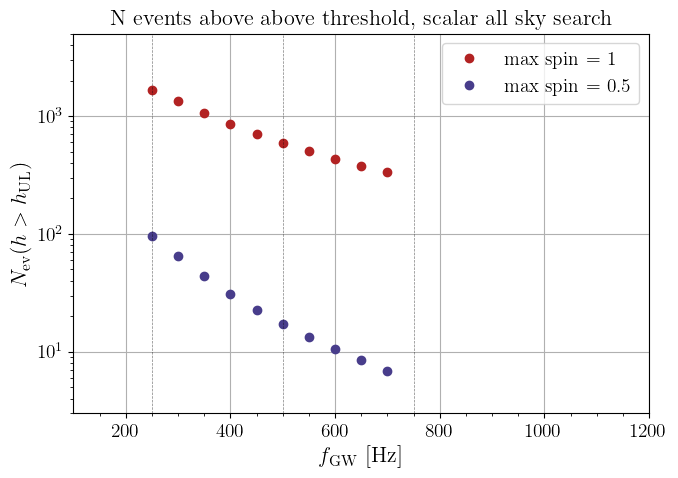

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16

ax.plot(fGW_List, Nev_List, 's', marker='o', c='firebrick', label='max spin = 1')
ax.plot(fGW_List_2, 2*Nev_List_2, 's', marker='o', c='darkslateblue', label='max spin = 0.5')
ax.set_yscale('log')
ax.set_title('N events above above threshold, scalar all sky search',fontsize=font_s);
ax.set_xlabel(r'$f_{\mathrm{GW}}$ [Hz]', fontsize=font_s); ax.set_ylabel(r'$N_{\mathrm{ev}}(h>h_{\mathrm{UL}})$', fontsize=font_s); 
ax.set_xlim(100,1200); ax.set_ylim(3,5E3)
ax.minorticks_on()
ax.axvline(x=250, ls='--', linewidth=0.5, c='k', alpha=0.5)
ax.axvline(x=500, ls='--', linewidth=0.5, c='k', alpha=0.5)
ax.axvline(x=750, ls='--', linewidth=0.5, c='k', alpha=0.5)
ax.grid()
ax.legend()

fig.tight_layout()
fig.savefig('figs/Nev_scalar_allsky.pdf', bbox_inches="tight")

### Events as a function of BH mass

In [ ]:
hList = np.geomspace(1E-27, 1E-24, 300)
dNevdlogM = np.zeros((len(ipList), len(MList)))

for ip in ipList:
    dNevdlogM[ip] = get_dNevdlogM_ip(Ntot=3000, p_ind=ip)

In [63]:
ipList = np.arange(10)
hList = np.geomspace(1E-27, 1E-24, 300)
Ntot = 3000

dfdlogh_ip = np.zeros((len(ipList), len(hList)))
dNevdlogM = np.zeros((len(ipList), len(MList)))

for ip in ipList:
    dfdlogh_ip[ip], dNevdlogM[ip] = get_Nev_distributions(hList, Ntot=Ntot, p_ind=ip)

100%|██████████| 300/300 [00:31<00:00,  9.48it/s]


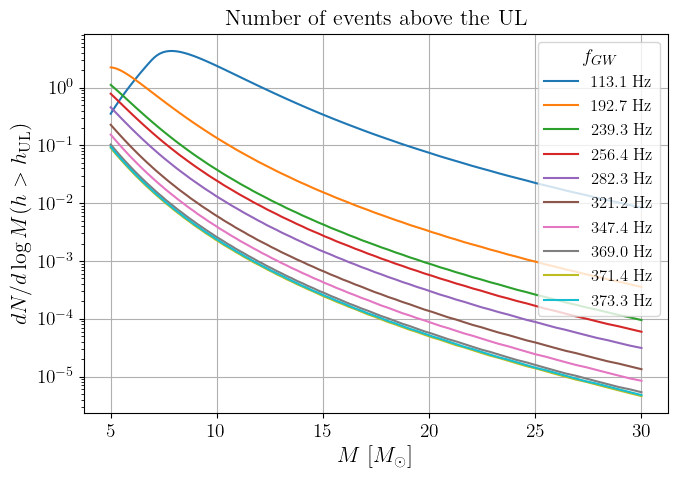

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16

for ip in ipList:
    line,=ax.plot(MList, dNevdlogM[ip], label=str(round(df_pulsars['F_GW'].iloc[ip], 1))+' Hz')

ax.set_yscale('log')
ax.set_xlabel(r'$M\ [M_{\odot}]$', fontsize=font_s); ax.set_ylabel(r'$dN/d\log M (h>h_{\mathrm{UL}})$', fontsize=font_s); 
ax.set_title('Number of events above the UL', fontsize=font_s);
ax.legend(title='$f_{GW}$', fontsize=12)
#ax.set_ylim(0.01,1000)
ax.grid()

fig.tight_layout()
#fig.savefig('figs/dndlogM_pulsars.pdf', bbox_inches="tight")

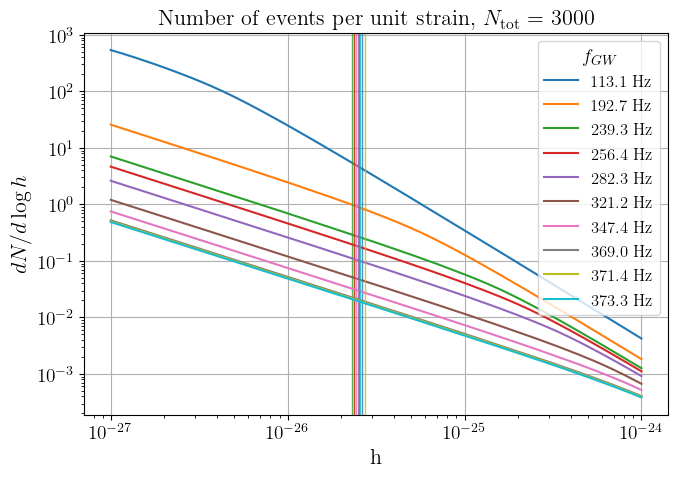

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green', 'teal'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16

Ntot = 3000

#selh = (hList > hUL)
#Nev = Ntot*np.trapz(dfdlogh[selh]/hList[selh], x=hList[selh])

for ip in ipList:
    line,=ax.plot(hList, Ntot*dfdlogh_ip[ip], label=str(round(df_pulsars['F_GW'].iloc[ip], 1))+' Hz')
    ax.axvline(x=df_pulsars['upper limits'].iloc[ip], linewidth=1, alpha=0.8, c=line.get_color())

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'h', fontsize=font_s); ax.set_ylabel(r'$dN/d\log h$', fontsize=font_s); 
ax.set_title('Number of events per unit strain, $N_{\mathrm{tot}} =$ '+str(Ntot), fontsize=font_s);
ax.legend(title='$f_{GW}$', fontsize=12)
#ax.set_ylim(0.01,1000)
ax.grid()

fig.tight_layout()
#fig.savefig('figs/dndlogh_pulsars.pdf', bbox_inches="tight")

In [68]:
Nev_above_th = np.zeros((len(ipList), 2))
Ntot = 3000

for ip in ipList:
    hUL = df_pulsars['upper limits'].iloc[ip]
    Nev_above_th[ip, 0] = df_pulsars['F_GW'].iloc[ip]
    
    selh = (hList > hUL)
    Nev_above_th[ip, 1] = Ntot*np.trapz(dfdlogh_ip[ip][selh]/hList[selh], x=hList[selh])

In [69]:
Nev_above_th

array([[1.13076026e+02, 2.24134932e+00],
       [1.92724470e+02, 6.87761794e-01],
       [2.39297466e+02, 2.48294371e-01],
       [2.56410256e+02, 1.66902924e-01],
       [2.82290106e+02, 9.30834868e-02],
       [3.21185420e+02, 4.44811274e-02],
       [3.47416438e+02, 2.95183970e-02],
       [3.69003690e+02, 1.97115548e-02],
       [3.71448554e+02, 1.72114428e-02],
       [3.73303340e+02, 1.79668894e-02]])

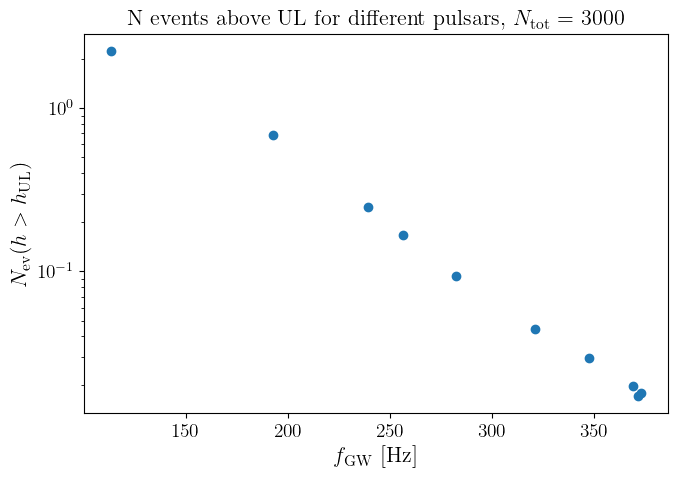

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16

ax.plot(Nev_above_th[:, 0], Nev_above_th[:, 1], 's', marker='o')

ax.set_title('N events above UL for different pulsars, $N_{\mathrm{tot}} =$ '+str(Ntot),fontsize=font_s);
ax.set_xlabel(r'$f_{\mathrm{GW}}$ [Hz]', fontsize=font_s); ax.set_ylabel(r'$N_{\mathrm{ev}}(h>h_{\mathrm{UL}})$', fontsize=font_s); 
ax.set_yscale('log')
#ax.grid()
#ax.set_xlim(100,300); #ax.set_ylim(0,10)

fig.tight_layout()
#fig.savefig('figs/Nexpected.pdf', bbox_inches="tight")

## Plots

Normalization =  1.0002145481580622


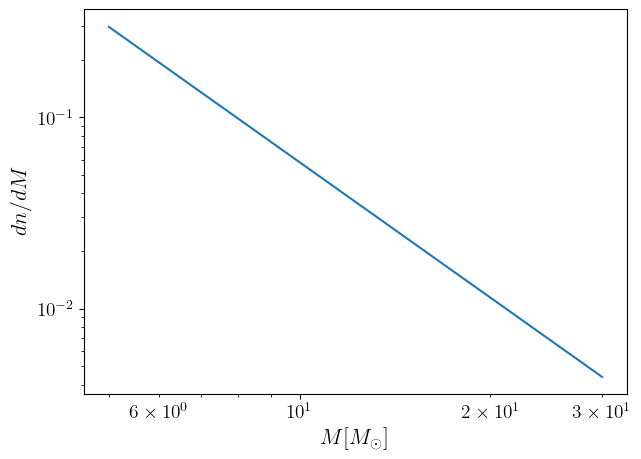

In [8]:
### BH mass distributon

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
font_s=16

MList = np.geomspace(Mmin, Mmax, 100) #np.arange(Mmin, Mmax, 0.2)
print('Normalization = ', str(np.trapz(dndM(MList), x=MList)))

ax.plot(MList, dndM(MList))
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'$M [M_{\odot}]$', fontsize=font_s)
ax.set_ylabel(r'$dn/dM$', fontsize=font_s);

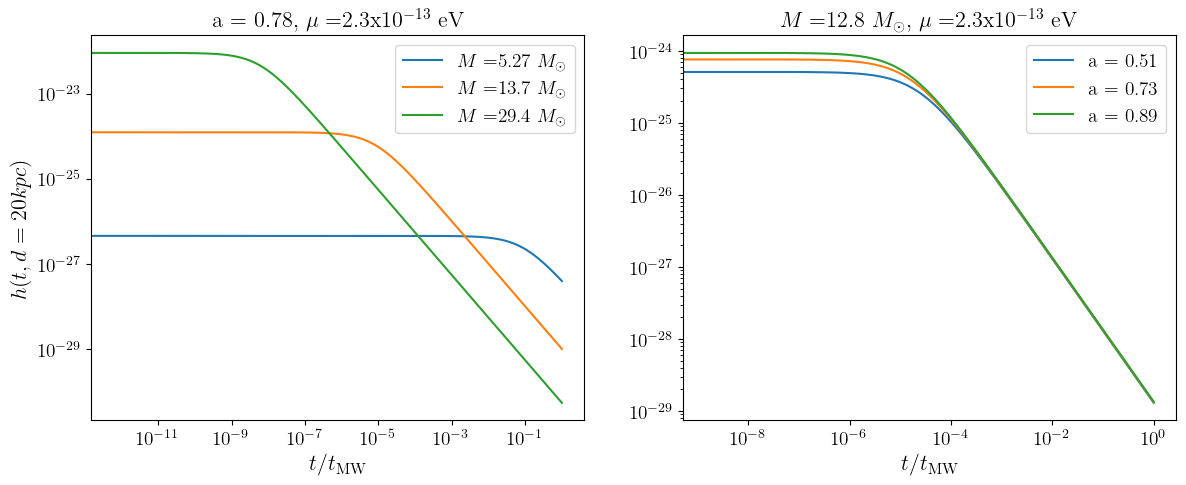

In [27]:
### Check the computed strains hTilde for a few valaues of M and a

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16
sub_im = np.array([3, 56, 98])
i_a = 78

mu = np.pi*df_pulsars['F_GW'].iloc[p_ind]*Hz

for i in sub_im:
    ax[0].plot(tGrid[i, i_a, :], hTilde[i, i_a, :], label=r'$M = $'+str(MList[i])[:4]+'$\ M_{\odot}$')
    
i_m = 52
sub_ia = np.array([51, 73, 89])

for i in sub_ia:
    ax[1].plot(tGrid[i_m, i, :], hTilde[i_m, i, :], label=r'a = '+str(aList[i])[:4])

ax[0].set_title(r'a = '+str(aList[i_a])[:4]+', $\mu = $'+str(mu/eV/1e-13)[:3]+'x$10^{-13}$ eV', fontsize=font_s);
ax[1].set_title(r'$M = $'+str(MList[i_m])[:4]+'$\ M_{\odot}$, $\mu = $'+str(mu/eV/1e-13)[:3]+'x$10^{-13}$ eV', fontsize=font_s);

for i in range(2):
    ax[i].set_xscale('log'); ax[i].set_yscale('log')
    ax[i].set_xlabel(r'$t/t_{\mathrm{MW}}$', fontsize=font_s)
    ax[0].set_ylabel(r'$h(t, d=20 kpc)$', fontsize=font_s);
    ax[i].legend()

# Tests

In [3]:
bc = ub.UltralightBoson(spin=1, model="relativistic") 

In [4]:
mbh = 10
abh0 = 0.5
alpha = 0.02

wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")

if wf.azimuthal_num()==1:
    tauGW = wf.gw_time()*Second

In [5]:
tauSR = wf.cloud_growth_time()
tauGW = wf.gw_time()
tauSR/1E9, tauGW/1e13

(4.345572030927802, 2.84590924589311)

In [6]:
wf.strain_char(-10, dObs=0.001) # distance in Mpc

4.5728003476743694e-24

In [7]:
wf.strain_char(-1E9, dObs=0.001)

6.532471187190322e-42

In [8]:
tList = np.geomspace(1E-5,1E7,100)*tauGW #np.concatenate([ np.sort(np.logspace(-9,0,50)*(-tauSR)), np.logspace(-13, 2, 200)*tauGW ] )  
hList = wf.strain_char(tList, dObs=0.001)

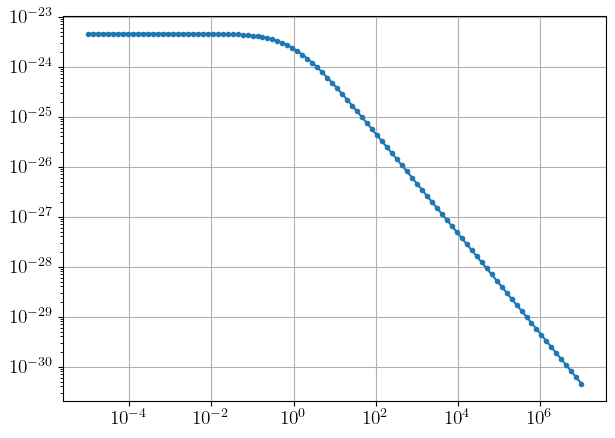

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']

#ax.plot((tList+tauSR)[1:], hList[1:])
ax.plot(tList/tauGW, hList, marker='.')
ax.set_xscale('log'); ax.set_yscale('log')
ax.grid()

In [10]:
def get_dfdlogh_diff(hVal, hTilde, fMList):
    
    thFnc = np.heaviside((hVal/hTilde-1), np.zeros(hTilde.shape))
    integrand = 3*( (hTilde/hVal) )**3*thFnc*fMList[:,None,None]
    
    return integrand

In [15]:
hList = np.geomspace(1E-28, 1E-24, 100)

hList_Grid = np.full((len(hList),len(MList), len(aList), tSteps), hList[:, np.newaxis, np.newaxis, np.newaxis])

hTilde_Gridh = np.full((len(hList),len(MList), len(aList), tSteps), hTilde[np.newaxis, :, :, :])
print(hList_Grid.shape, hTilde_Gridh.shape)

(100, 100, 100, 500) (100, 100, 100, 500)


In [16]:
fMList = dndM(MList)
fMList.shape

(100,)

In [17]:
thFnc = np.heaviside((1-hTilde_Gridh/hList_Grid), np.zeros(hTilde_Gridh.shape))

In [ ]:
thFnc.shape